<a href="https://colab.research.google.com/github/aarushiwagh/TBInterventionAnalysis/blob/main/TB_Test_Ntbk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import scipy
import numpy as np
import pandas as pd
import pprint 

In [ ]:
A = scipy.array([[6, 3, 4, 8], [3, 6, 5, 1], [4, 5, 10, 7], [8, 1, 7, 25]])
L=scipy.linalg.cholesky(A,lower=True)
print("A:")
pprint.pprint(A)
pprint.pprint(L)

A:
array([[ 6,  3,  4,  8],
       [ 3,  6,  5,  1],
       [ 4,  5, 10,  7],
       [ 8,  1,  7, 25]])
array([[ 2.44948974,  0.        ,  0.        ,  0.        ],
       [ 1.22474487,  2.12132034,  0.        ,  0.        ],
       [ 1.63299316,  1.41421356,  2.30940108,  0.        ],
       [ 3.26598632, -1.41421356,  1.58771324,  3.13249102]])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  """Entry point for launching an IPython kernel.


# Monte Carlo Sims


In [ ]:
!pip install mcerp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 290 kB 24.2 MB/s 
  Created wheel for mcerp: filename=mcerp-0.12-py3-none-any.whl size=22831 sha256=d2e3d98758a69f33826f31e70edaa1f9528cc9c34f8879f97fd22f09753cd6b4
  Stored in directory: /root/.cache/pip/wheels/a8/fe/8e/36655e5d300a31602be3d4833feb6b0a4250b4f7412bb32fcc
Successfully built mcerp


In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mcerp import correlate, correlation_matrix, plotcorr
from mcerp import Beta, N, Exp, PERT
from mcerp import uv, stats
# from mcerp import *

from scipy import stats as stats
from scipy.stats import rv_continuous, beta, genextreme, rv_histogram
import scipy.optimize as opt


import warnings
warnings.filterwarnings("ignore")

np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = '{:.3f}'.format

nR = 10000

In [ ]:
# distribution parameters:
min, mode, max, lmb = 8000.0, 12000.0, 18000.0, 4.0         # sales volume, PERT estimae
ms, ss = 20.0, 1.0                                          # selling price, normally distributed
mm, sm = 13.0, 0.7                                          # material unit cost, normally distributed 
o = 3.0      

In [ ]:
# setting up the simulation model BEFORE calibrating correlations:

# input variables:
v1 = PERT(min, mode, max, lmb)                  # sales volume, PERT distributed
p1 = N(ms, ss)                                  # selling price, normally distributed
m1 = N(mm, sm)                                  # material unit cost, normally distributed 
o1 = o                                          # other unit cost, deterministic    


# output variables:
GP1 = v1 * (p1 - m1 - o1)                       # simulation output: Gross Profit
R1 = v1 * p1                                    # simulation output: Revenues
GM1 = GP1 / R1                                  # simulation output: Gross Margin
C1 = R1 - GP1           

In [ ]:
# run the simulation model, 
# and collect the results in array variables

# number of mcerp samples
npts = nR

# assign the 6x 10,000 values to 6 variables so we can process their arrays later
rv1 = v1._mcpts
rp1 = p1._mcpts
rm1 = m1._mcpts
rGP1 = GP1._mcpts
rR1 = R1._mcpts
rGM1 = GM1._mcpts

# combine the 6 arrays in a 2-dimensional array
rand1 = np.vstack((rv1, rp1, rm1, rGP1, rR1, rGM1))

# copy the array to a dataframe for a more transparent layout
df1 = pd.DataFrame(data=rand1).T 
df1.rename(columns={ 
    0:"volume 1", 1:"price 1", 2:"material 1", 3:"Gross Profit 1", 4:"Revenues 1", 5:"Gross Margin 1"}, 
    inplace=True)
df1

,volume 1,price 1,material 1,Gross Profit 1,Revenues 1,Gross Margin 1
0,10469.242,21.256,14.104,43468.881,222537.758,0.195
1,14816.446,20.669,12.965,69704.004,306244.207,0.228
2,11731.796,19.688,12.739,46332.078,230978.409,0.201
3,12432.519,18.203,12.191,37444.269,226309.219,0.165
4,12553.803,21.582,13.089,68953.561,270937.435,0.254
...,...,...,...,...,...,...
9995,11396.101,22.893,14.793,58115.197,260887.472,0.223
9996,11603.476,19.940,12.843,47544.293,231374.807,0.205
9997,12648.355,21.135,13.135,63237.034,267323.065,0.237
9998,12307.097,19.314,13.830,30561.953,237695.325,0.129


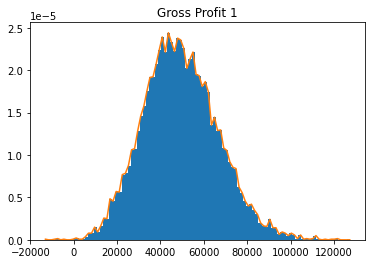

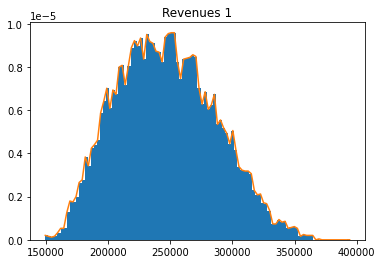

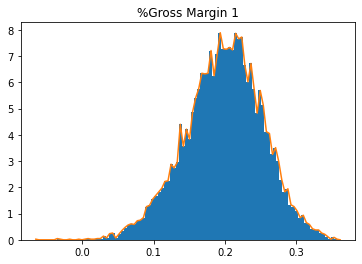

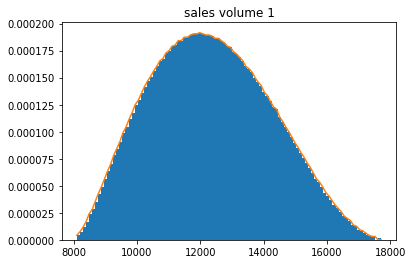

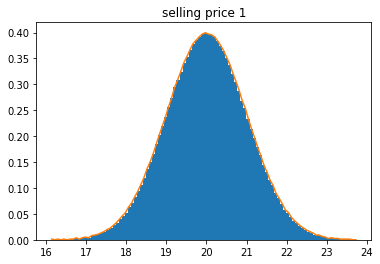

In [ ]:
# helper function: plot histogram
def plot_hist(data, title):
    hist = np.histogram(data, bins=100)
    histdist = rv_histogram(hist)

    X = np.linspace(data.min(), data.max(), 100)
    plt.title(title)
    plt.hist(data, density=True, bins=100)
    plt.plot(X, histdist.pdf(X))
    plt.show()
    
    
    # results: draw histograms
plot_hist(rGP1, "Gross Profit 1")
plot_hist(rR1, "Revenues 1")
plot_hist(rGM1, "%Gross Margin 1")
plot_hist(rv1, "sales volume 1")
plot_hist(rp1, "selling price 1")